## Bachelor Thesis - Informatik

### Variante 2 :
### Multiclass-Klassifizierung von Greyscale-Bildern mit Convolutional Neuronal Network

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

#### ☑️ Ein eigener Datensatz der aus selbst aufgezeichneten Gesten eines Myo-Armbands besteht

#### ☑️ Ein Datensatz der bei Kaggle zur Verfügung steht

#### ☑️ Ein Datensatz der aus dem Ninapro DB5 Datensatz abgeleitet wurde

##### ▶️ Installation notwendiger Python-Bibliotheken

In [297]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install -U seaborn-image
#%pip install matplotlib.pyplot
#%pip install scikit-learn

##### ▶️ Importieren notwendiger Python-Bibliotheken

In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##### ▶️ Alternative 1 : Einlesen der eigenen Roh-Daten aus dem Quellordner<br>
****
📌 Dieses Feld ausführen bei Verwendung der Eigen-Daten !!

In [24]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', '4']:
    single_data.append(pd.read_csv('./Eigene/P0L' + label + '.csv', sep=';', header=None))    
    single_data[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)
all_data = all_data.dropna()
all_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
549,-110,-60,-10,0,190,20,0,20,-50.0,-40.0,...,-90.0,-50.0,-60.0,0.0,30.0,240.0,-20.0,-10.0,-10.0,4
550,30,20,10,-190,20,20,40,-50,30.0,-20.0,...,140.0,40.0,-10.0,-10.0,0.0,20.0,0.0,10.0,-140.0,4
551,-70,10,-20,-100,-110,30,-190,80,10.0,10.0,...,-60.0,50.0,20.0,0.0,50.0,120.0,0.0,-20.0,-30.0,4
552,30,30,-10,-170,40,-10,90,-60,-30.0,-30.0,...,30.0,0.0,-10.0,-50.0,-200.0,-150.0,-10.0,0.0,170.0,4
553,10,-180,-70,0,100,-10,-50,0,40.0,20.0,...,-20.0,10.0,-10.0,0.0,-20.0,100.0,30.0,50.0,30.0,4


##### ▶️ Alternative 2 : Einlesen des Datensatzes von Kaggle aus dem Quellordner

****
📌 Dieses Feld ausführen bei Verwendung der Kaggle-Daten !!

[Link zum Datensatz](https://www.kaggle.com/code/akshita72/hand-gesture-recognition-from-emg-signals/input)

In [36]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema:
# Label 0 --> Stein
# Label 1 --> Schere
# Label 2 --> Papier
# Label 3 --> OK-Zeichen


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', ]:
    single_data.append(pd.read_csv('./Kaggle/' + label + '.csv', sep=',', header=None))    
    

##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)
all_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
11673,-3.0,-1.0,-1.0,-1.0,-28.0,20.0,5.0,0.0,-5.0,0.0,...,-3.0,1.0,4.0,3.0,4.0,-51.0,-49.0,5.0,-9.0,3
11674,-13.0,-5.0,-4.0,-3.0,-4.0,-24.0,-10.0,-8.0,20.0,9.0,...,6.0,-3.0,-3.0,-3.0,-5.0,-4.0,-45.0,-12.0,-15.0,3
11675,-1.0,-3.0,-1.0,1.0,30.0,38.0,-1.0,36.0,-10.0,1.0,...,14.0,-8.0,-4.0,-4.0,-4.0,-21.0,-29.0,-5.0,0.0,3
11676,1.0,4.0,4.0,5.0,9.0,-10.0,4.0,1.0,-2.0,-1.0,...,-16.0,-3.0,0.0,-3.0,-5.0,-36.0,-90.0,3.0,5.0,3
11677,-2.0,4.0,2.0,-4.0,12.0,3.0,-2.0,9.0,-8.0,-2.0,...,2.0,1.0,0.0,-1.0,-2.0,-30.0,64.0,11.0,5.0,3


##### ▶️ Alternative 3 : Einlesen von Daten aus dem Ninapro DB5 Datensatz<br>
****
📌 Dieses Feld ausführen bei Verwendung Ninapro-Daten !!

[Link zum Datensatz](https://ninapro.hevs.ch/instructions/DB5.html)

In [44]:
# Die Dateien im Ordner "Ninapro_DB5" enthalten Auszüge aus dem originalen Datensatz
# Aus den Matlab-Files wurden die 8 Sensorwerte und die zugehörigen Labels entnommen
# Es wurden nur die "Subjects" 01 bis 06 berücksichtigt

# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt

##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['1', '2', '3', '4', '5', '6']:
    single_data.append(pd.read_csv('./Ninapro_DB5/P' + label + '.csv', sep=';', header=None))    
    

##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)

all_data.tail()

,0,1,2,3,4,5,6,7,8
567995,-1,1,-2,-1,-1,0,0,3,0
567996,-2,2,-2,-3,-1,-3,-3,-2,0
567997,-3,-5,-3,-1,0,0,-2,3,0
567998,-5,0,0,-2,-1,-1,0,-3,0
567999,-1,-5,0,-1,0,0,0,-1,0


##### ▶️ Ansatz 1 : Umwandlung in Greyscale-Bilder mit allen Sensorkanälen pro Bild
****

📌 Dieses Feld für Bilder mit allen Sensorwerten pro Bild ausführen --> **unbedingt die richtige Label-Struktur einkommentieren !!**

****
☑️ Erzeugte Strukturen aus den Eigen-Daten haben das Format 16 x 8<br>
☑️ Erzeugte Strukturen aus den Kaggle-Daten haben das Format 16 x 64<br>
****
<br>
📌 Jede Struktur enthält alle 8 Sensorkanäle

In [46]:
def split_dataframe(df, n, reminder = None):
    # Get number of rows in DataFrame
    total_rows = len(df)
    
    # Initialize list to hold the split DataFrames
    dfs = []
    
    # Calculate the number of DataFrames
    num_dfs = total_rows // n
    extra_rows = total_rows % n
    
    if reminder == 'first' and extra_rows > 0:
        # Size of first chunk is equal to reminder. Remaining chunks are same size.
        dfs.append(df.iloc[:n + extra_rows])
        start_idx = n + extra_rows
        for _ in range(1, num_dfs):
            dfs.append(df.iloc[start_idx:start_idx + n])
            start_idx += n
    elif reminder == 'last' and extra_rows > 0:
        # Last chunk consists of remining rows. The other chunks are the same size.
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
        # Add extra rows to the last chunk
        dfs.append(df.iloc[num_dfs*n:])
    elif reminder == 'spread':
        # Evenly spread extra rows across the first few chunks
        for i in range(num_dfs + (1 if extra_rows > 0 else 0)):
            size = n + (1 if i < extra_rows else 0)
            dfs.append(df.iloc[i*size:min((i+1)*size, total_rows)])
    else:
        if extra_rows > 0:
            raise ValueError(f"DataFrame Länge ist nicht teilbar durch {n}. Bitte nutze den 'reminder' Parameter.")
        # If remainder is None and the DataFrame is perfectly divisible
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
    
    return dfs


##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
labels = all_data[all_data.columns[-1]]
 

##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
classes = np.unique(labels)
print("Classes Shape:",classes.shape)


##############################################################
# Sensorwerte der Gesten auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
#sensors = all_data.drop(8, axis=1).copy()
sensors = all_data.drop(64, axis=1).copy()

##############################################################
# Zerteile Gesamtdaten in Einzelpakete mit jeweils 16 Zeilen #
# Datentyp Python List                                       #
##############################################################
images = split_dataframe(sensors, 16, 'last')
labels = split_dataframe(labels, 16, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_images = len(images)-1
images = images[:l_images]

l_labels = len(labels)-1
labels = labels[:l_labels]


##############################################################
# Konvertiere die Listen in Numpy-Arrays                     #
# Datentyp Numpy-Array                                       #
##############################################################
images = np.array(images)
labels = np.array(labels)


#############################################################
# Reduziere die Dimension der Labels auf 1                   #
# Wichtig für das Convolution Neuronal Network !!            #
##############################################################
labels = labels[:,1]


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Images Shape: ", images.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Labels Shape:", labels.shape)


Classes Shape: (4,)
Images Shape:  (729, 16, 64)
Labels Shape: (729,)


##### ▶️ Ansatz 2 : Umwandlung in Greyscale-Bilder mit einem Sensorkanal pro Bild
****

📌 Dieses Feld für Bilder mit einem Sensorwert pro Bild ausführen<br>
📌 Dieser Ansatz benötigt Daten wie im Kaggle-Datensatz, also [8] x [8] Sensorwerte pro Zeile

****
☑️ Erzeugte Strukturen aus den Kaggle-Daten haben das Format 16 x 64<br>
****
<br>
📌 Jede Struktur enthält nur 1 Sensorkanal

In [38]:
def split_dataframe(df, n, reminder = None):
    # Get number of rows in DataFrame
    total_rows = len(df)
    
    # Initialize list to hold the split DataFrames
    dfs = []
    
    # Calculate the number of DataFrames
    num_dfs = total_rows // n
    extra_rows = total_rows % n
    
    if reminder == 'first' and extra_rows > 0:
        # Size of first chunk is equal to reminder. Remaining chunks are same size.
        dfs.append(df.iloc[:n + extra_rows])
        start_idx = n + extra_rows
        for _ in range(1, num_dfs):
            dfs.append(df.iloc[start_idx:start_idx + n])
            start_idx += n
    elif reminder == 'last' and extra_rows > 0:
        # Last chunk consists of remining rows. The other chunks are the same size.
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
        # Add extra rows to the last chunk
        dfs.append(df.iloc[num_dfs*n:])
    elif reminder == 'spread':
        # Evenly spread extra rows across the first few chunks
        for i in range(num_dfs + (1 if extra_rows > 0 else 0)):
            size = n + (1 if i < extra_rows else 0)
            dfs.append(df.iloc[i*size:min((i+1)*size, total_rows)])
    else:
        if extra_rows > 0:
            raise ValueError(f"DataFrame Länge ist nicht teilbar durch {n}. Bitte nutze den 'reminder' Parameter.")
        # If remainder is None and the DataFrame is perfectly divisible
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
    
    return dfs

##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
labels = all_data[all_data.columns[-1]]


##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
classes = np.unique(labels)
print("Classes Shape:",classes.shape)


##############################################################
# Zerlege Labels in Einzelpakete mit jeweils 1024 Zeilen     #
# Datentyp Python List                                       #
##############################################################
labels = split_dataframe(labels, 1024, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_labels = len(labels)-1
labels = labels[:l_labels]


##############################################################
# Array-Elemente in Format 704x16 konvertieren               #
# Datentyp Numpy Array                                       #
##############################################################  
labels = np.array(labels)
labels = labels.reshape(704, -1)


##############################################################
# Reduziere die Dimension der Labels auf 1                   #
# Wichtig für das Convolution Neuronal Network !!            #
##############################################################
labels = labels[:,1]


##############################################################
# Zerlege Sensorwert in Einzelpakete mit jeweils 1024 Zeilen #
# Datentyp Python List                                       #
##############################################################
sensors = all_data.drop(64, axis=1).copy()
split = split_dataframe(sensors, 1024, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_split = len(split)-1
split = split[:l_split]


##############################################################
# Reduziere die 3D-Array auf 2D-Array                        #
# Wichtig für das Convolution Neuronal Network !!            #
# Datentyp Numpy Array                                       #
##############################################################
split = np.array(split)
split = split.reshape(-1, split.shape[-1])


##############################################################
# Lese die Spalten aus den Sensorwerten in neue Liste ein    #
# Dies ist jeder Sensorkanal einzeln                         #
# Datentyp Pandas Dataframe --> split --> wegen columns      #
# Datentyp Liste --> single_sensors --> wegen append()       #
##############################################################
single_sensors = []
split = pd.DataFrame(split)

for i in range(len(split.columns)):
   single_sensors.append(split_dataframe(split[i], 16, 'last'))


##############################################################
# Array-Elemente in Format 16x64 konvertieren                #
# Datentyp Numpy Array                                       #
##############################################################  
single_sensors = np.array(single_sensors)
single_sensors = single_sensors.reshape(-1,16,64)
images = single_sensors


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Images Shape: ", images.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Labels Shape:", labels.shape)

Classes Shape: (4,)
Images Shape:  (704, 16, 64)
Labels Shape: (704,)


#### ▶️ Normalisierung der Daten

In [47]:

##############################################################
# Datenskalierung mit Min-/Max Prinzip                       #
# Skalierung auf Werte von 0 bis 255 als Pixel               #
##############################################################  
sc = MinMaxScaler(feature_range=(0,255))


##############################################################
# Umwandlung aller Daten ins Pixelformat                     #
# Datentyp Numpy Array                                       #
##############################################################  
for i, df in enumerate(images):
    images[i] = sc.fit_transform(images[i])


#### ▶️ Darstellung der erzeugten Grayscale-Bilder

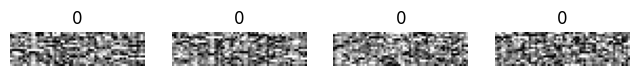

In [48]:

fig = plt.figure(figsize=(8, 4)) # type: ignore

for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i],cmap='gray', vmin=0, vmax=255)    
    plt.title(labels[i])
    plt.axis("off")
    

### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [114]:
##############################################################
# Einkommentieren für eigene Daten und Ninapro               #
# Klassen entsprechen der vorhandenen Gesten                 #
##############################################################
#num_classes = 7


##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
num_classes = 4


##############################################################
# Einkommentieren für eigene Daten und Ninapro               #
# Bei 8 Sensorwerten  pro Zeile --> (16, 8, 1)               #
# Bei 64 Sensorwerten pro Zeile --> (16, 64, 1)              #
##############################################################
#input_shape = (16, 8, 1)


##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fix 64 Sensorwerte pro Zeile --> (16, 64, 1)               #
##############################################################
input_shape = (16, 64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 100) # type: ignore


##############################################################
# Konvertieren auf Wertebereich 0.0 bis 1.0                  #
##############################################################
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255


##############################################################
# Vierte Dimension für Algorithmus hinzufügen                #
##############################################################
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
print("y_train Vectorform:", y_train.shape)
print("y_test Vectorform:", y_test.shape)
print()
print(images.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train Vectorform: (510, 16, 64, 1)
X_test Vectorform: (219, 16, 64, 1)
y_train Vectorform: (510,)
y_test Vectorform: (219,)

729 Gesamtwerte
510 Trainingswerte
219 Testwerte


#### ▶️ Modellarchitektur in Anlehnung an folgende Publikation :<br>

###### "S-Convnet: A Shallow Convolutional Neural Network Architecture for Neuromuscular Activity Recognition Using Instantaneous High-Density Surface EMG Images"<br>

###### [Link]https://ieeexplore.ieee.org/document/9175266)

📌 Der Ansatz die EMG-Daten in Bilder umzuwandeln wurde diesem Paper entnommen

In [164]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 128
epochs = 50

initializer='glorot_uniform'
#initializer='glorot_normal'
#initializer='he_uniform'
#initializer='he_normal'
#initializer='lecun_uniform'
#initializer='lecun_normal'
#initializer='ones'
#initializer='zeros'

padding='same'

##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv2D(64, (4,4), padding = padding, strides=2, input_shape=input_shape, kernel_initializer=initializer))
model.add(layers.Activation('elu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(2,2))

model.add(layers.Conv2D(64, (4,4), padding = padding, strides=2))
model.add(layers.Activation('elu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(256))
model.add(layers.Activation('elu'))

model.add(layers.Dense(num_classes, activation = 'softmax'))

# Modellparameter ausgeben
model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)             │ (None, 8, 32, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 8, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 8, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 4, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 2, 8, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_156 (Activation)     │ (None, 2, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 2, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 1, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_157 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,508 (521.52 KB)

 Trainable params: 133,508 (521.52 KB)

 Non-trainable params: 0 (0.00 B)

In [165]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2012 - loss: 1.4317 - val_accuracy: 0.2549 - val_loss: 1.3942 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2607 - loss: 1.3972 - val_accuracy: 0.3039 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2695 - loss: 1.3758 - val_accuracy: 0.3333 - val_loss: 1.3822 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3201 - loss: 1.3688 - val_accuracy: 0.2059 - val_loss: 1.3933 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2939 - loss: 1.3543 - val_accuracy: 0.2255 - val_loss: 1.3752 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2956 - loss: 1.3454 - val_accuracy: 0.3627 - val_loss: 1.3574 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4810 - loss: 1.3203 - val_accuracy: 0.4314 

### ▶️ Ausgabe der Funktionen für Verlust und Genauigkeit

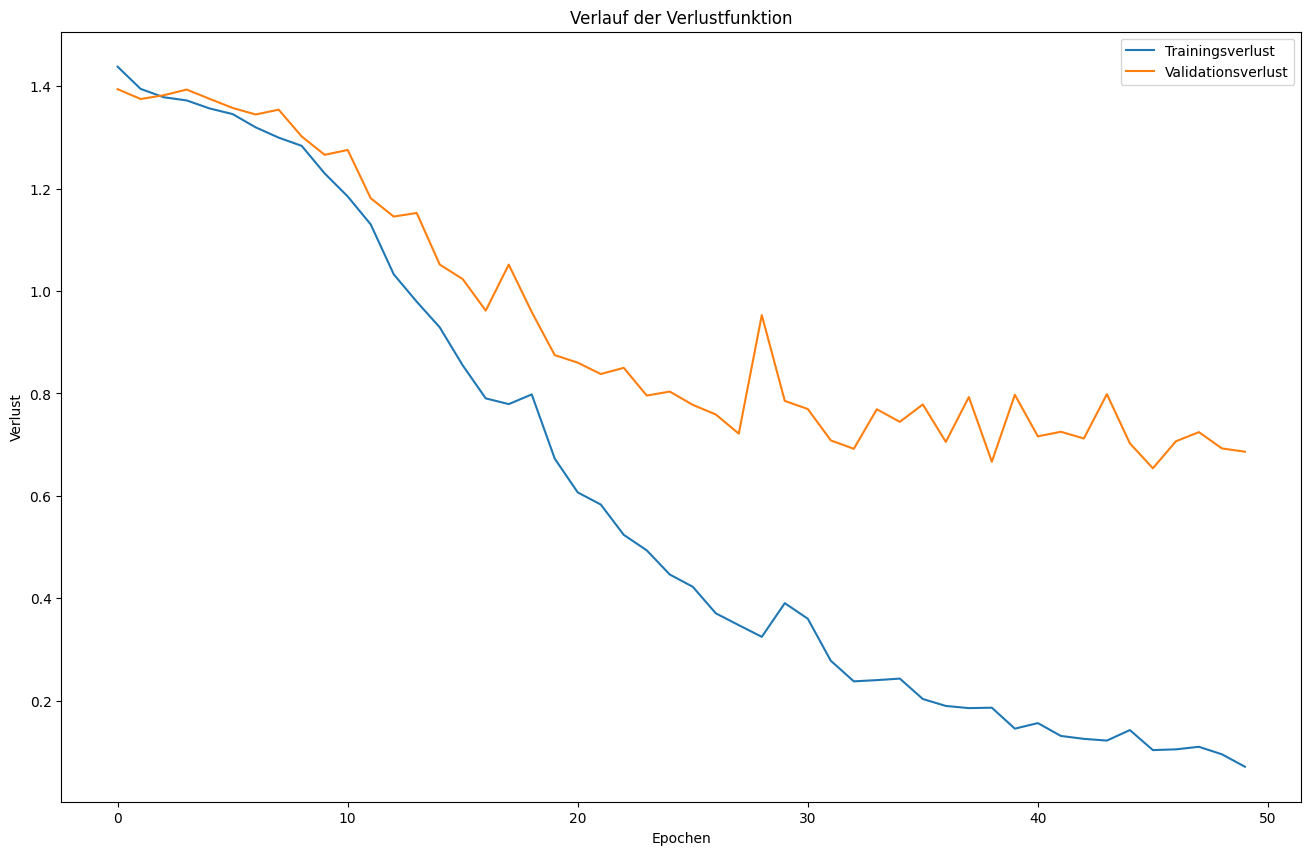

In [166]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

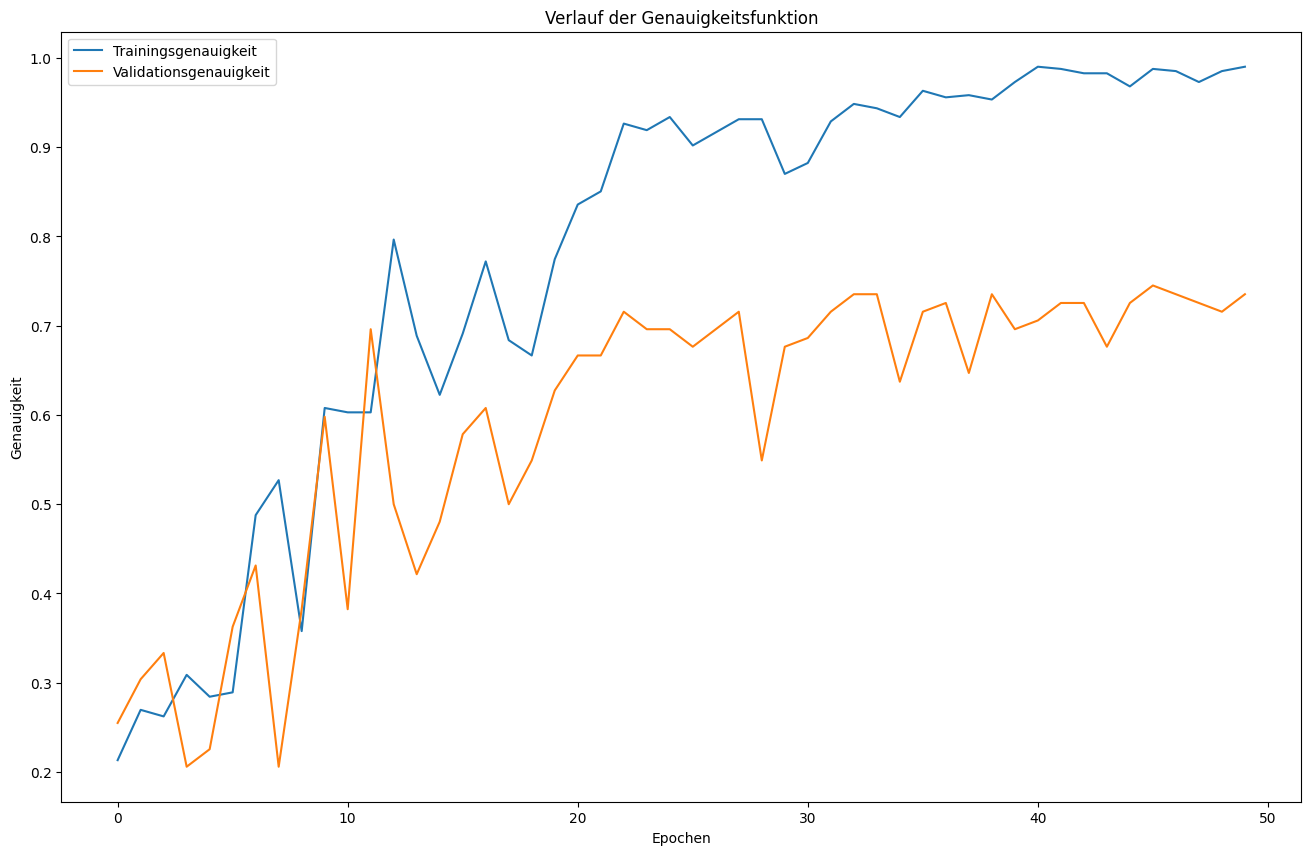

In [167]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Scores zur Beurteilung der Modellqualität 

In [168]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Testverlust :", score[0])
print("Testgenauigkeit :", score[1])

Testverlust : 0.6432622075080872
Testgenauigkeit : 0.7579908967018127


### ▶️ Metriken zur Beurteilung der Modellqualität 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


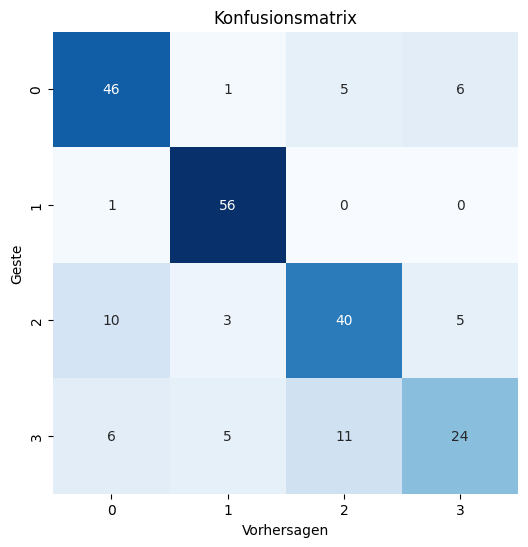

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        58
           1       0.86      0.98      0.92        57
           2       0.71      0.69      0.70        58
           3       0.69      0.52      0.59        46

    accuracy                           0.76       219
   macro avg       0.75      0.75      0.74       219
weighted avg       0.75      0.76      0.75       219



In [169]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
# 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))